# Considerações Iníciais


Os comentários chamados de "Observações", contém:
- as minha ideias
- problemas encontrados
- conclusões

- Conexão com o Banco MySQL

In [12]:
# Instalações
!pip install mysql-connector-python
!pip install matplotlib
!pip install seaborn
!pip install -U scikit-learn



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [13]:
# Importações
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

In [14]:
# Infos para a conexão
user = 
password = 
host = 
database = 
port = 

In [15]:
# Conecta ao banco de dados
connection = mysql.connector.connect(
    user=user,
    password=password,
    host=host,
    database=database,
    port=port,
    connection_timeout=1000
)

# Instância o cursor
cursor = connection.cursor()

In [16]:
# Tabelas do banco de dados
cursor.execute("SHOW TABLES")
tables = cursor.fetchall()

# Lista as tabelas
for table in tables:
    print(table[0])

daumau
desinstalacoes
installs
ratings_reviews


# 1- Comentários:
- A quantida de linhas nas tabelas são diferentes
- Para melhor visualizar vou transformar essas tabelas em dataframes do Pandas.

In [17]:
#  Número de linhas e colunas para cada tabela
for table in tables:
    table_name = table[0]

    # Conta as linhas da tabela
    cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
    row_count = cursor.fetchone()[0]

    # Obtem a quantidade de colunas da tabela
    cursor.execute(f"DESCRIBE {table_name}")
    columns = cursor.fetchall()
    column_count = len(columns)

    print(f"Tabela: {table_name} | Linhas: {row_count} | Colunas: {column_count}")

Tabela: daumau | Linhas: 41299 | Colunas: 4
Tabela: desinstalacoes | Linhas: 53188 | Colunas: 5
Tabela: installs | Linhas: 48150 | Colunas: 3
Tabela: ratings_reviews | Linhas: 47155 | Colunas: 7


# Observações:
- Segundo o contexto a variável alvo seria a "Daily Active Users (DAU)", entretanto não existe uma variável com esse nome.
A variável com o nome mais aproximado é a "dauReal" e por essa razão eu vou assumir que ela é o alvo.
- Não foi disponibilizado dicionário de dados, e me parece ser muito importante saber a diferença entre as variáveis "dauReal" e "mauReal".
- Como todas as tabelas tem uma coluna "appId" e uma coluna de data, é necessário observar a quantidade de valores unícos de "appId" para saber se os dados foram agrupados por evento ou por id (entretando essa coluna parece ser um evento/categoria/agrupamento).

In [18]:
# Dicionário para salvar os dataframes
dataframes = {}

# Iterar sobre as tabelas, extrair dados e salvar em DataFrames
for table in tables:
    table_name = table[0]

    # Obter os nomes das colunas da tabela
    cursor.execute(f"DESCRIBE {table_name}")
    columns = [col[0] for col in cursor.fetchall()]

    # Obter todos os dados da tabela
    cursor.execute(f"SELECT * FROM {table_name}")
    rows = cursor.fetchall()

    # Criar o DataFrame com os dados e os nomes das colunas
    df = pd.DataFrame(rows, columns=columns)

    # Armazenar o DataFrame no dicionário
    dataframes[table_name] = df

In [19]:
# Visualizar todos as tabelas
for table_name, df in dataframes.items():
    print(f"Tabela: {table_name}")
    print(df)
    print("\n" + "="*50 + "\n")

Tabela: daumau
               appId        date   dauReal    mauReal
0      com.app.33540  2024-01-01  393961.0  3643110.0
1      com.app.33540  2024-01-02  800448.0  3643040.0
2      com.app.31679  2024-01-01  157532.0  1349262.0
3      com.app.31679  2024-01-02  313847.0  1349317.0
4      com.app.77385  2024-01-01  239768.0  1934660.0
...              ...         ...       ...        ...
41294           None  2044-07-13  130203.0   578280.0
41295           None  2044-07-14    7412.0    36137.0
41296           None  2044-07-15   81544.0   854480.0
41297           None  2044-07-16   49957.0   173394.0
41298           None  2044-07-17    1932.0    16373.0

[41299 rows x 4 columns]


Tabela: desinstalacoes
               appId       date country lang  predictionLoss
0      com.app.71740 2024-01-01      br   pt            1463
1      com.app.33540 2024-01-01      br   pt            8170
2      com.app.19544 2024-01-01      br   pt           77048
3      com.app.77385 2024-01-01      br   

In [20]:
# Renomear colunas que começam com 'app' para 'appid' em cada DataFrame
for table_name, df in dataframes.items():
    df.rename(columns={col: 'appid' for col in df.columns if col.startswith('app')}, inplace=True)

In [21]:
# Verificar a quantidade de valores únicos da coluna 'appId' em cada DataFrame
for table_name, df in dataframes.items():
    if 'appid' in df.columns:
        unique_appId_count = df['appid'].nunique()  # Conta valores únicos
        print(f"Tabela: {table_name} | Valores únicos de 'appId': {unique_appId_count}")
    else:
        print(f"Tabela: {table_name} não possui a coluna 'appId'")


Tabela: daumau | Valores únicos de 'appId': 195
Tabela: desinstalacoes | Valores únicos de 'appId': 195
Tabela: installs | Valores únicos de 'appId': 182
Tabela: ratings_reviews | Valores únicos de 'appId': 182


In [22]:
# Valores nulos e ausentes para cada coluna de cada DataFrame
for table_name, df in dataframes.items():
    print(f"Tabela: {table_name}")
    absent_counts = df.isna().sum()  # Contar valores ausentes (nulos e NaN)

    # Exibir contagens
    for column in df.columns:
        print(f"Coluna: {column} | Valores ausentes/nulos: {absent_counts[column]}")


Tabela: daumau
Coluna: appid | Valores ausentes/nulos: 28
Coluna: date | Valores ausentes/nulos: 0
Coluna: dauReal | Valores ausentes/nulos: 194
Coluna: mauReal | Valores ausentes/nulos: 20
Tabela: desinstalacoes
Coluna: appid | Valores ausentes/nulos: 0
Coluna: date | Valores ausentes/nulos: 0
Coluna: country | Valores ausentes/nulos: 0
Coluna: lang | Valores ausentes/nulos: 0
Coluna: predictionLoss | Valores ausentes/nulos: 0
Tabela: installs
Coluna: appid | Valores ausentes/nulos: 0
Coluna: date | Valores ausentes/nulos: 0
Coluna: newinstalls | Valores ausentes/nulos: 0
Tabela: ratings_reviews
Coluna: date | Valores ausentes/nulos: 0
Coluna: appid | Valores ausentes/nulos: 0
Coluna: category | Valores ausentes/nulos: 0
Coluna: ratings | Valores ausentes/nulos: 0
Coluna: daily_ratings | Valores ausentes/nulos: 0
Coluna: reviews | Valores ausentes/nulos: 0
Coluna: daily_reviews | Valores ausentes/nulos: 0


# Observações:
- Considerando que os valore nulos são restritos a tabela "daumau" e não são muitos, juntei os dataframes tomando por base a coluna "AppId".
- A coluna "AppId" está em todas as tabelas, e em todas um mesmo "AppId" aparece varias vezes.
- Logo, a coluna "AppId foi utilizada como chave.
- Não foi possível juntar as tabelas por data e AppId, pois o "AppId" das tabelas não têm a mesma data.
- No final os valores nulos foram removidos, pois eram poucos e não valeria a pena substituir esses dados através de "imputação".

In [23]:
# Lista para armazenar os DataFrames renomeados
dataframes_renomeados = []

# Processa todas as tabelas
for table_name, df in dataframes.items():
    # Remover duplicatas
    #df = df.drop_duplicates()

    # Renomea todas as colunas para incluir o nome da tabela, exceto a coluna 'appId'
    df.columns = [f"{col}_{table_name}" if col != 'appid' else col for col in df.columns]

    # Adiciona o DataFrame renomeado à lista
    dataframes_renomeados.append(df)

# Realiza merge (join) utilizando a coluna 'appId' como chave
final_df = pd.concat(dataframes_renomeados, axis=0, join='outer')

# Agrupa pelo 'appId' e combinar todas as informações em uma única linha por 'appId'
final_df = final_df.groupby('appid').first().reset_index()

In [24]:
final_df["appid"].value_counts().tail()

appid
com.app.39929    1
com.app.40009    1
com.app.41189    1
com.app.41993    1
com.app.99432    1
Name: count, dtype: int64

In [25]:
final_df.shape[0]

195

In [26]:
# Valores nulos por variável
final_df.isnull().sum()

appid                             0
date_daumau                       0
dauReal_daumau                    2
mauReal_daumau                    1
date_desinstalacoes               0
country_desinstalacoes            0
lang_desinstalacoes               0
predictionLoss_desinstalacoes     0
date_installs                    13
newinstalls_installs             13
date_ratings_reviews             13
category_ratings_reviews         13
ratings_ratings_reviews          13
daily_ratings_ratings_reviews    13
reviews_ratings_reviews          13
daily_reviews_ratings_reviews    13
dtype: int64

In [27]:
# Valores nulos totais
final_df.isnull().sum().sum()

np.int64(107)

In [28]:
# Remove os valores nan
final_df = final_df.dropna()

In [29]:

final_df.isnull().sum().sum()

np.int64(0)

In [30]:
# Confere a quantidade de linhas
final_df.shape[0]

181

# Observações:
- As colunas lang_desinstalacoes e country_desinstalacoes possuem somente observações "br".
- Por essa razão serão excluídas.

In [31]:
from typing import final
# Essa variável possui apenas dados "br"
final_df["lang_desinstalacoes"].value_counts()

lang_desinstalacoes
pt    181
Name: count, dtype: int64

In [32]:
final_df["country_desinstalacoes"].value_counts()


country_desinstalacoes
br    181
Name: count, dtype: int64

In [33]:
# Remover duas colunas específicas
final_df = final_df.drop(columns=['country_desinstalacoes', 'lang_desinstalacoes'])


# Observações:
- A minha intenção não é fazer uma análise aprofundada desses dados
- Apesar disso, é legal visualizar a distribição e relação das váriáveis

In [34]:
final_df

,appid,date_daumau,dauReal_daumau,mauReal_daumau,date_desinstalacoes,predictionLoss_desinstalacoes,date_installs,newinstalls_installs,date_ratings_reviews,category_ratings_reviews,ratings_ratings_reviews,daily_ratings_ratings_reviews,reviews_ratings_reviews,daily_reviews_ratings_reviews
0,com.app.10626,2024-03-23,223700.0,1950503.0,2024-01-01,30372.0,2024-01-01,4064.0,2024-01-01,FINANCE,418299.0,210.0,111173.0,88.0
3,com.app.13421,2024-05-15,826841.0,2667280.0,2024-01-01,30033.0,2024-01-01,3038.0,2024-01-01,FINANCE,423868.0,37.0,46972.0,27.0
4,com.app.13655,2024-01-01,10149.0,77387.0,2024-01-01,1569.0,2024-01-01,881.0,2024-01-01,FINANCE,62744.0,1.0,26406.0,1.0
6,com.app.14509,2024-01-01,777969.0,5880590.0,2024-01-01,37538.0,2024-01-01,24465.0,2024-01-01,FINANCE,1242231.0,149.0,584161.0,136.0
7,com.app.14811,2024-01-01,11466.0,107133.0,2024-01-01,1166.0,2024-01-01,966.0,2024-01-01,FINANCE,8363.0,0.0,4708.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,com.app.97802,2024-01-01,2160.0,55413.0,2024-01-01,7483.0,2024-01-01,191.0,2024-01-01,OTHERS,2401.0,2.0,1006.0,0.0
190,com.app.97976,2024-01-01,4090.0,86561.0,2024-01-01,9631.0,2024-01-01,870.0,2024-01-01,SHOPPING,7930.0,5.0,3000.0,1.0
191,com.app.97988,2024-01-01,5790.0,60640.0,2024-01-01,6269.0,2024-01-01,362.0,2024-01-01,SHOPPING,10744.0,0.0,4233.0,0.0
192,com.app.98198,2024-01-01,1871.0,23779.0,2024-01-01,1912.0,2024-01-01,25.0,2024-01-01,OTHERS,3940.0,1.0,2130.0,2.0


<Figure size 1800x1200 with 0 Axes>

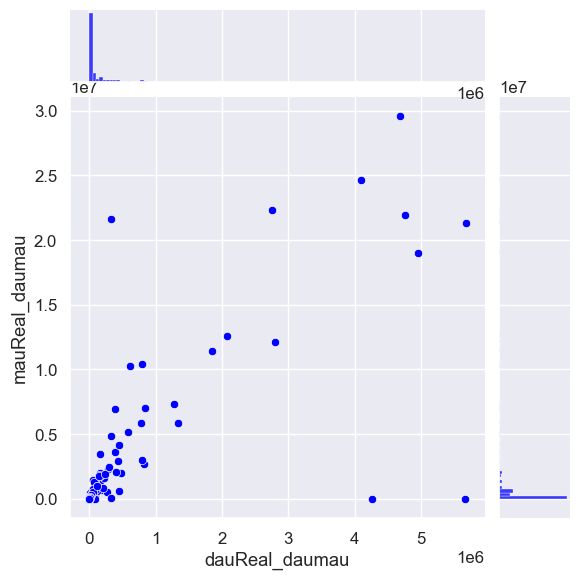

In [35]:
# @title Relação entre dauReal_daumau e mauReal_daumau
# Plot
plt.figure(figsize = (18, 12))
sns.set(font_scale = 1.1)
sns.jointplot(data = final_df,
            x = 'dauReal_daumau',
            y = 'mauReal_daumau',
            color = 'blue')

- Observando o histograma, podemos perceber que a variável alvo não segue uma distirbuição normal (o que dificulta as coisas)
- Observando o gráfico de dispersão, parece haver correlação entre duas variáveis. Vamos confirmar calculando o coeficiente de correlação entre elas.

In [36]:
# Correlação
final_df[['dauReal_daumau', 'mauReal_daumau']].corr()

,dauReal_daumau,mauReal_daumau
dauReal_daumau,1.000000,0.762578
mauReal_daumau,0.762578,1.000000


<Figure size 1800x1200 with 0 Axes>

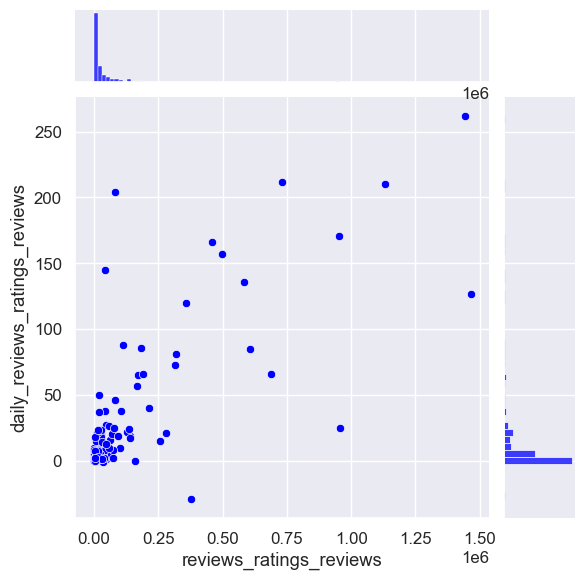

In [37]:
# @title Relação entre reviews_ratings_reviews e daily_reviews_ratings_reviews

# Plot
plt.figure(figsize = (18, 12))
sns.set(font_scale = 1.1)
sns.jointplot(data = final_df,
            x = 'reviews_ratings_reviews',
            y = 'daily_reviews_ratings_reviews',
            color = 'blue')

- Observando o histograma, podemos perceber que as variáveis não seguem uma distribuição normal.
- Observando o gráfico de dispersão, parece haver correlação entre duas variáveis. Vamos confirmar calculando o coeficiente de correlação entre elas.

In [38]:
# Correlação
final_df[['reviews_ratings_reviews', 'daily_reviews_ratings_reviews']].corr()

,reviews_ratings_reviews,daily_reviews_ratings_reviews
reviews_ratings_reviews,1.000000,0.769686
daily_reviews_ratings_reviews,0.769686,1.000000


<Figure size 1800x1200 with 0 Axes>

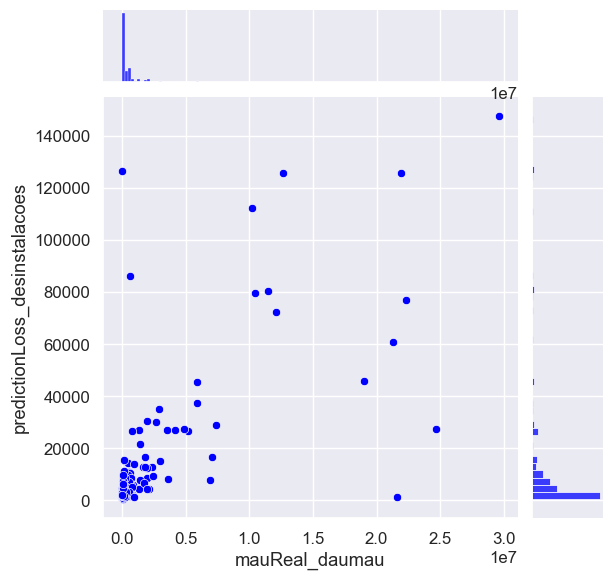

In [39]:
# @title Relação entre mauReal_daumau e predictionLoss_desinstalacoes

# Plot
plt.figure(figsize = (18, 12))
sns.set(font_scale = 1.1)
sns.jointplot(data = final_df,
            x = 'mauReal_daumau',
            y = 'predictionLoss_desinstalacoes',
            color = 'blue')

- Observando o histograma, podemos perceber que as variáveis não seguem uma distribuição normal.
- Observando o gráfico de dispersão, parece haver correlação entre duas variáveis. Vamos confirmar calculando o coeficiente de correlação entre elas.

In [40]:
# Correlação
final_df[['mauReal_daumau', 'predictionLoss_desinstalacoes']].corr()

,mauReal_daumau,predictionLoss_desinstalacoes
mauReal_daumau,1.000000,0.702735
predictionLoss_desinstalacoes,0.702735,1.000000


 # Importante!
Em regressão queremos que as variáveis preditoras tenham uma boa correlação com a variável alvo. Entretanto, não queremos uma alta correlação entre as variáveis predidoras, sendo caso de multicolinearidade.

- Plot de um modelo linear
- O lmplot cria a linha de regressão e a margem de erro.
- A variável "mauReal_daumau" foi a utilizada pois ela parece ter alguma relação com o target (ainda não consegui identificar o que essas variáveis significam)

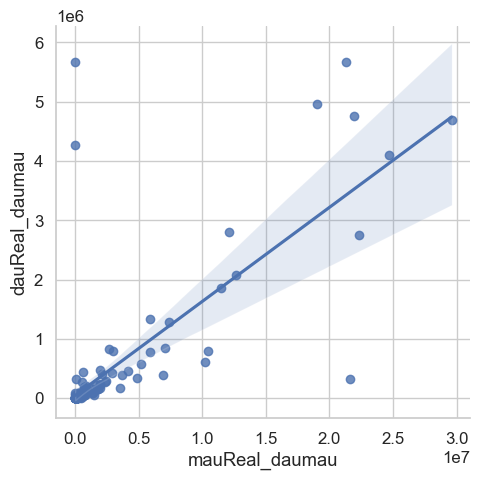

In [41]:
# Plot
sns.set(font_scale = 1.1)
sns.set_style('whitegrid')
sns.lmplot(y = "dauReal_daumau", x = "mauReal_daumau", data =  final_df)

In [42]:
final_df.columns

Index(['appid', 'date_daumau', 'dauReal_daumau', 'mauReal_daumau',
       'date_desinstalacoes', 'predictionLoss_desinstalacoes', 'date_installs',
       'newinstalls_installs', 'date_ratings_reviews',
       'category_ratings_reviews', 'ratings_ratings_reviews',
       'daily_ratings_ratings_reviews', 'reviews_ratings_reviews',
       'daily_reviews_ratings_reviews'],
      dtype='object')

In [43]:
# Remove as colunas de datas
final_df = final_df.drop(columns=['date_daumau', 'date_desinstalacoes', 'date_installs', 'date_ratings_reviews'])


In [44]:
final_df.columns

Index(['appid', 'dauReal_daumau', 'mauReal_daumau',
       'predictionLoss_desinstalacoes', 'newinstalls_installs',
       'category_ratings_reviews', 'ratings_ratings_reviews',
       'daily_ratings_ratings_reviews', 'reviews_ratings_reviews',
       'daily_reviews_ratings_reviews'],
      dtype='object')

In [45]:
# Remove a coluna de Appid
final_df = final_df.drop(columns=['appid'])

# Observações:
- A variável "category_ratings_reviews" foi "dumizada".
- Foi analisada a multicolinearidade entre as variáveis preditoras.
- Algumas variáveis possuem uma colinearidade de 0,8 com outras, o que é considerado um pouco alto. Entretanto, vou manter essas variáveis e verificar se elas não serão eliminadas na fase de "feature importance".

In [46]:
# Dumizando a variável 'category_ratings_reviews'
dummies = pd.get_dummies(final_df['category_ratings_reviews'], prefix='category')

# Concatenando as colunas dumizadas com o DataFrame original
final_df = pd.concat([final_df, dummies], axis=1)

# Removendo a coluna original, se necessário
final_df.drop('category_ratings_reviews', axis=1, inplace=True)

final_df.head(5)

,dauReal_daumau,mauReal_daumau,predictionLoss_desinstalacoes,newinstalls_installs,ratings_ratings_reviews,daily_ratings_ratings_reviews,reviews_ratings_reviews,daily_reviews_ratings_reviews,category_BUSINESS,category_FINANCE,category_FOOD_AND_DRINK,category_OTHERS,category_SHOPPING,category_TRAVEL_AND_LOCAL
0,223700.0,1950503.0,30372.0,4064.0,418299.0,210.0,111173.0,88.0,False,True,False,False,False,False
3,826841.0,2667280.0,30033.0,3038.0,423868.0,37.0,46972.0,27.0,False,True,False,False,False,False
4,10149.0,77387.0,1569.0,881.0,62744.0,1.0,26406.0,1.0,False,True,False,False,False,False
6,777969.0,5880590.0,37538.0,24465.0,1242231.0,149.0,584161.0,136.0,False,True,False,False,False,False
7,11466.0,107133.0,1166.0,966.0,8363.0,0.0,4708.0,0.0,False,True,False,False,False,False


In [47]:
final_df.corr()

,dauReal_daumau,mauReal_daumau,predictionLoss_desinstalacoes,newinstalls_installs,ratings_ratings_reviews,daily_ratings_ratings_reviews,reviews_ratings_reviews,daily_reviews_ratings_reviews,category_BUSINESS,category_FINANCE,category_FOOD_AND_DRINK,category_OTHERS,category_SHOPPING,category_TRAVEL_AND_LOCAL
dauReal_daumau,1.000000,0.762578,0.567278,0.620057,0.422862,0.298724,0.678930,0.498735,-0.058189,0.038229,-0.005399,0.090815,-0.056190,-0.082670
mauReal_daumau,0.762578,1.000000,0.702735,0.750141,0.402332,0.311185,0.717192,0.586198,0.036288,0.018270,0.021083,-0.005443,-0.000256,-0.087153
predictionLoss_desinstalacoes,0.567278,0.702735,1.000000,0.832667,0.590470,0.518056,0.788715,0.721668,-0.017017,-0.036695,0.146656,0.027779,-0.000936,-0.072313
newinstalls_installs,0.620057,0.750141,0.832667,1.000000,0.585776,0.503580,0.797145,0.738375,-0.067631,0.025860,0.165503,-0.032435,0.030772,-0.094849
ratings_ratings_reviews,0.422862,0.402332,0.590470,0.585776,1.000000,0.895177,0.858651,0.710254,-0.059280,0.025819,0.323156,-0.058109,-0.043662,-0.069284
daily_ratings_ratings_reviews,0.298724,0.311185,0.518056,0.503580,0.895177,1.000000,0.664736,0.723845,-0.063284,0.012542,0.362191,-0.031851,-0.077719,-0.063740
reviews_ratings_reviews,0.678930,0.717192,0.788715,0.797145,0.858651,0.664736,1.000000,0.769686,-0.055255,0.068249,0.167499,-0.041359,-0.026158,-0.092922
daily_reviews_ratings_reviews,0.498735,0.586198,0.721668,0.738375,0.710254,0.723845,0.769686,1.000000,-0.034769,0.121466,0.138144,-0.045252,-0.085389,-0.103046
category_BUSINESS,-0.058189,0.036288,-0.017017,-0.067631,-0.059280,-0.063284,-0.055255,-0.034769,1.000000,-0.250179,-0.062459,-0.181773,-0.138800,-0.079212
category_FINANCE,0.038229,0.018270,-0.036695,0.025860,0.025819,0.012542,0.068249,0.121466,-0.250179,1.000000,-0.161141,-0.468970,-0.358101,-0.204364


# Observações
- Verifica a presença de outliers
- Separa os dados em treino e teste (optei por não separar também em validação, pois a quantidade de linhas diminuiu muito)
- Padronização -  Para esse conjunto de dados, talvez a padronização não seria necessária, pois os dados estão praticamente na mesma escala.
No entanto, vamos seguir as premissas do modelo de regressão.

In [48]:
final_df.head(2)

,dauReal_daumau,mauReal_daumau,predictionLoss_desinstalacoes,newinstalls_installs,ratings_ratings_reviews,daily_ratings_ratings_reviews,reviews_ratings_reviews,daily_reviews_ratings_reviews,category_BUSINESS,category_FINANCE,category_FOOD_AND_DRINK,category_OTHERS,category_SHOPPING,category_TRAVEL_AND_LOCAL
0,223700.0,1950503.0,30372.0,4064.0,418299.0,210.0,111173.0,88.0,False,True,False,False,False,False
3,826841.0,2667280.0,30033.0,3038.0,423868.0,37.0,46972.0,27.0,False,True,False,False,False,False


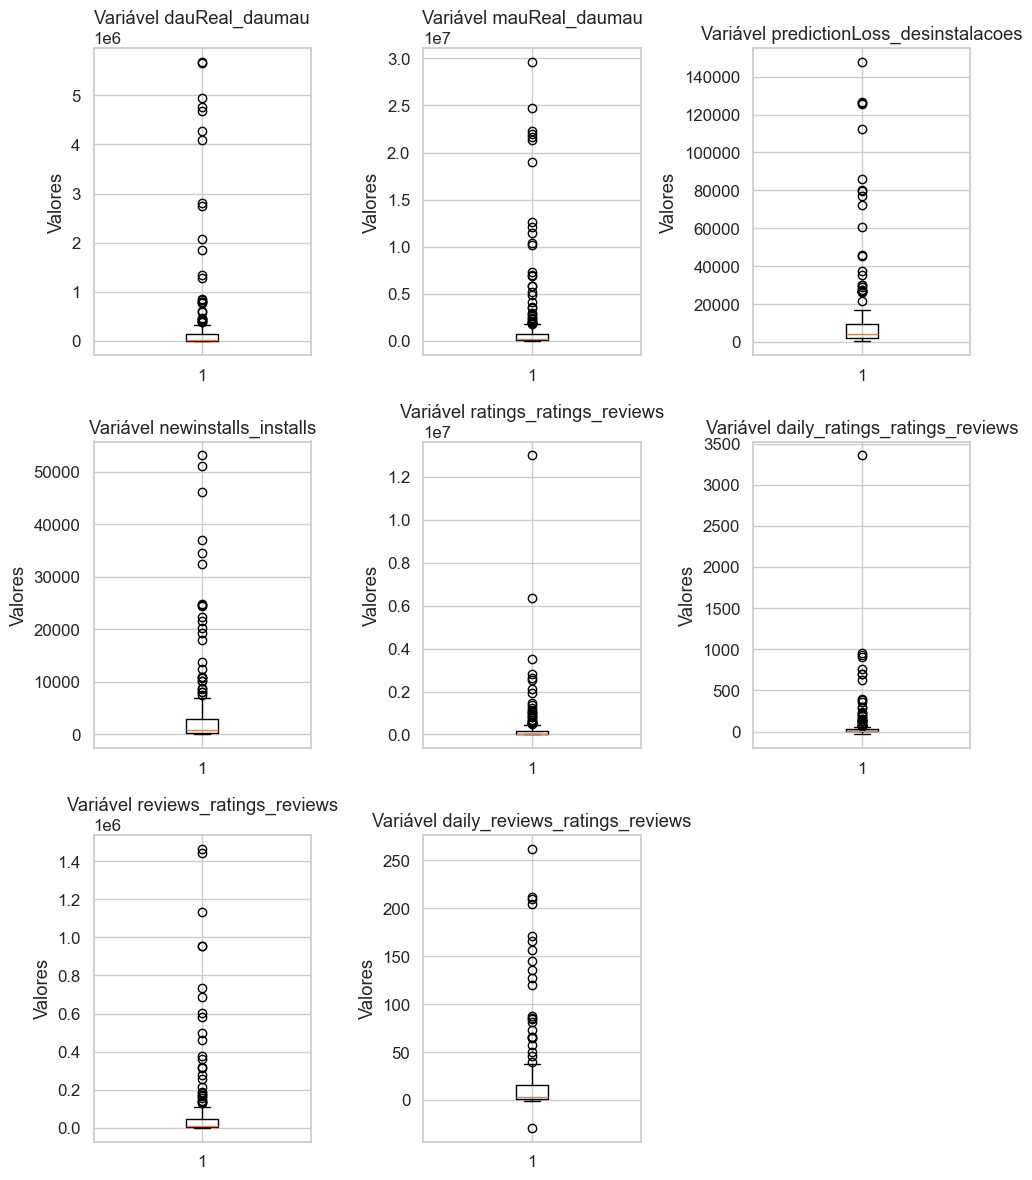

In [49]:
# Colunas a serem excluídas
excluir_colunas = [
    'category_TRAVEL_AND_LOCAL',
    'category_SHOPPING',
    'category_OTHERS',
    'category_FOOD_AND_DRINK',
    'category_FINANCE',
    'category_BUSINESS'
]

# Filtra as colunas para incluir apenas aquelas que não estão na lista de exclusão
variaveis = [col for col in final_df.columns if col not in excluir_colunas]

# Definindo o número de linhas e colunas para o layout dos gráficos
num_variaveis = len(variaveis)

# Número de colunas
ncols = 3
nrows = (num_variaveis + ncols - 1) // ncols  # calcula o número de linhas

plt.figure(figsize=(10, 4 * nrows))

for i, var in enumerate(variaveis):
    plt.subplot(nrows, ncols, i + 1)
    plt.boxplot(final_df[var])
    plt.title(f'Variável {var}')
    plt.ylabel('Valores')

plt.tight_layout()  # ajusta o layout
plt.show()

In [50]:
camingo_arquivo = '/Users/erichenriquedasilvapassos/Downloads/Rank_My_App/data/df_tratado.csv'
final_df.to_csv(camingo_arquivo, index=False)

# Fim da fase 1